In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)


In [2]:
df1 = pd.read_csv('Bengaluru_House_Data.csv')
df1.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape


(13320, 9)

In [4]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [6]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [8]:
df3.shape


(13246, 5)

In [9]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

/tmp/ipykernel_15437/2222900254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [11]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [12]:
df3['bhk'].unique()


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [13]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


#problem
you cannot have 43 bhk in 2400 sqft

In [14]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(2067,), dtype=object)

In [15]:
def is_float(x): #to check whether all value are float
  try:
    float(x)
  except:
    return False
  return True

In [16]:
# df3[df3['total_sqft'].apply(is_float)].head() #this gives the ones with float values

In [17]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


now to address this range issue

In [18]:
def convert_sqft_to_num(x):
  tokens = x.split('-')
  if(len(tokens) ==2):
    return (float(tokens[0]) + float(tokens[1]))//2
  try:
    return float(x)
  except:
    return None

In [19]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num);

In [20]:
df4.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


In [21]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

#feature engineering

removing unnecessary size column

In [22]:
df5 =df4.drop(['size'],axis='columns')

In [23]:
df5.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


adding a column of price per sqft

In [24]:
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']

In [25]:
df5.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [26]:
df5['price_per_sqft'] = df5['price_per_sqft'].round(2)

In [27]:
df5.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.89
4,Kothanur,1200.0,2.0,51.00,2,4250.00


In [28]:
len(df5.location.unique())

1304

In [29]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                              535
Sarjapur  Road                          392
Electronic City                         304
Kanakpura Road                          266
Thanisandra                             236
                                       ... 
Duddanahalli                              1
Doddanakunte                              1
Jogupalya                                 1
Subhash Nagar                             1
Kengeri Satellite Town KHB Apartment      1
Name: count, Length: 1293, dtype: int64

#lets say we will remove the data points with count<=10

In [30]:
len(location_stats[location_stats<=10])


1052

#DIMENSIONALITY REDUCTION

name location whose count <=10 as 'other'

In [31]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Sector 1 HSR Layout                     10
Basapura                                10
Nagadevanahalli                         10
BTM 1st Stage                           10
Nagappa Reddy Layout                    10
                                        ..
Duddanahalli                             1
Doddanakunte                             1
Jogupalya                                1
Subhash Nagar                            1
Kengeri Satellite Town KHB Apartment     1
Name: count, Length: 1052, dtype: int64

In [32]:
len(df5.location.unique())


1293

In [33]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

242

#Outlier Removal Using Business Logic

normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [34]:
df5[df5.total_sqft/df5.bhk >=300].head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.89
4,Kothanur,1200.0,2.0,51.00,2,4250.00


In [35]:
df6 = df5[df5.total_sqft/df5.bhk >=300]

In [36]:
df6.shape

(12456, 6)

In [37]:
# calculate the mean of price per sqft
df6['price_per_sqft'].describe()

count     12456.000000
mean       6308.513720
std        4168.123571
min         267.830000
25%        4210.530000
50%        5294.120000
75%        6916.670000
max      176470.590000
Name: price_per_sqft, dtype: float64

In [38]:
# prompt: outlier removal using mean and standard deviation

mean = df6['price_per_sqft'].mean()
#calculate standard deviation
std = df6['price_per_sqft'].std()
# #calculate the upper and lower limits
upper_limit = mean + std
lower_limit = mean - std
# #filter the data points whose price_per_sqft are within the limits
df7 = df6[(df6['price_per_sqft'] <= upper_limit) & (df6['price_per_sqft'] >= lower_limit)]
df7.shape


(11294, 6)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like



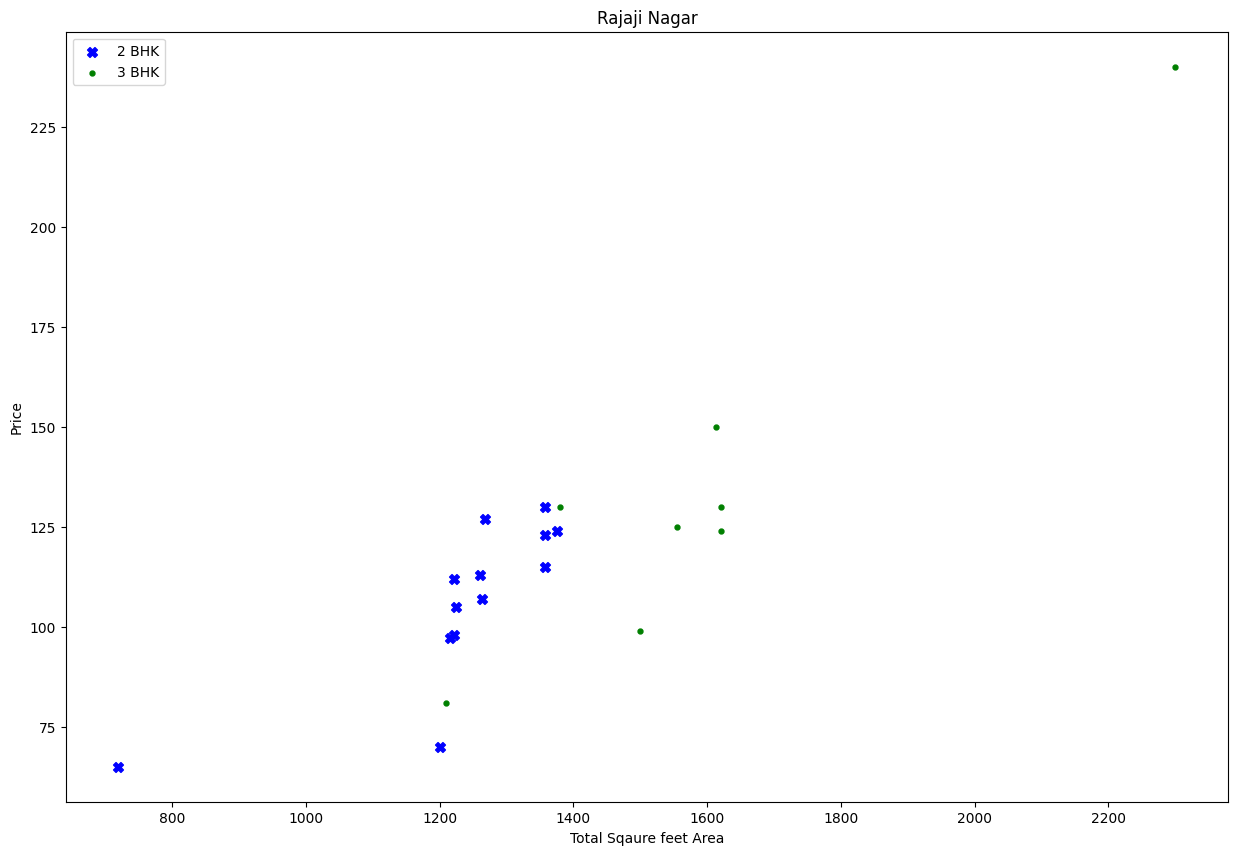

In [39]:
def plot_chart(df,location): #function to plot bhk in price vs sqft area
    bhk2 = df[(df.location == location) & (df.bhk==2)] # bhk dataset for location =location and bhk =2
    bhk3 =df[(df.location == location) & (df.bhk==3)]
    plt.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',marker='X',label='2 BHK',s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,color='green',marker='.',label='3 BHK',s=50)
    plt.xlabel("Total Sqaure feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

plot_chart(df7,"Rajaji Nagar")

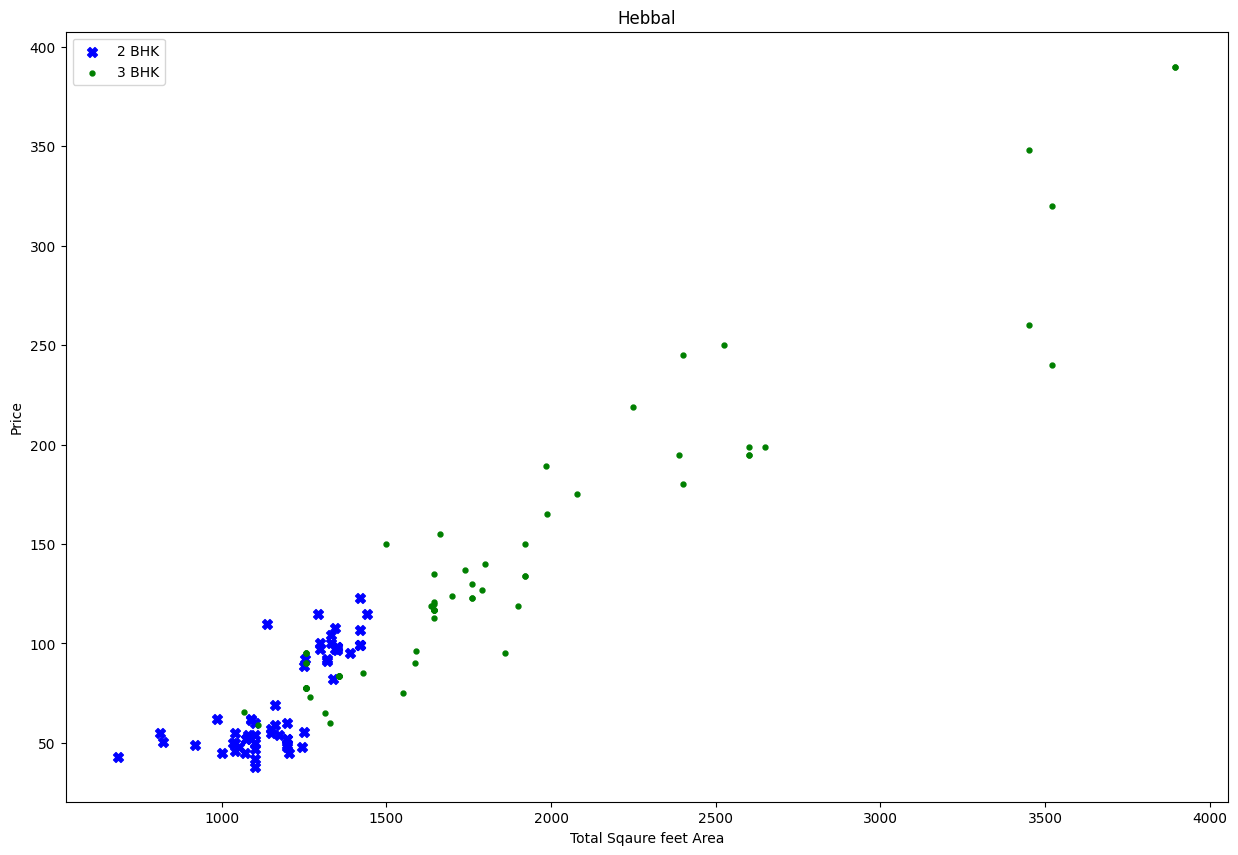

In [40]:
plot_chart(df7,"Hebbal")

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment



In [41]:
def remove_bhk_outliers(df):
    """
    This function removes outliers in a DataFrame (df) containing house price information
    based on location (categorical) and number of bedrooms (bhk - numerical).

    """

    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            # Calculate mean, standard deviation, and count for price_per_sqft of this bhk type
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)  # Get stats of the previous bhk type (if it exists)
            if stats and stats['count'] > 5:  # Ensure enough data points in previous bhk
                # Identify outliers in current bhk as those below the mean of previous bhk - 1.5 standard deviations
                outlier_indices = bhk_df[bhk_df.price_per_sqft < (stats['mean'] - 1.5 * stats['std'])].index.values
                exclude_indices = np.append(exclude_indices, outlier_indices)

    return df.drop(exclude_indices, axis='index')

# Example usage (assuming df7 is your DataFrame)
df8 = remove_bhk_outliers(df7.copy())  # Create a copy to avoid modifying the original df7
print(df8.shape)  # Print the shape of the DataFrame after outlier removal


(10992, 6)


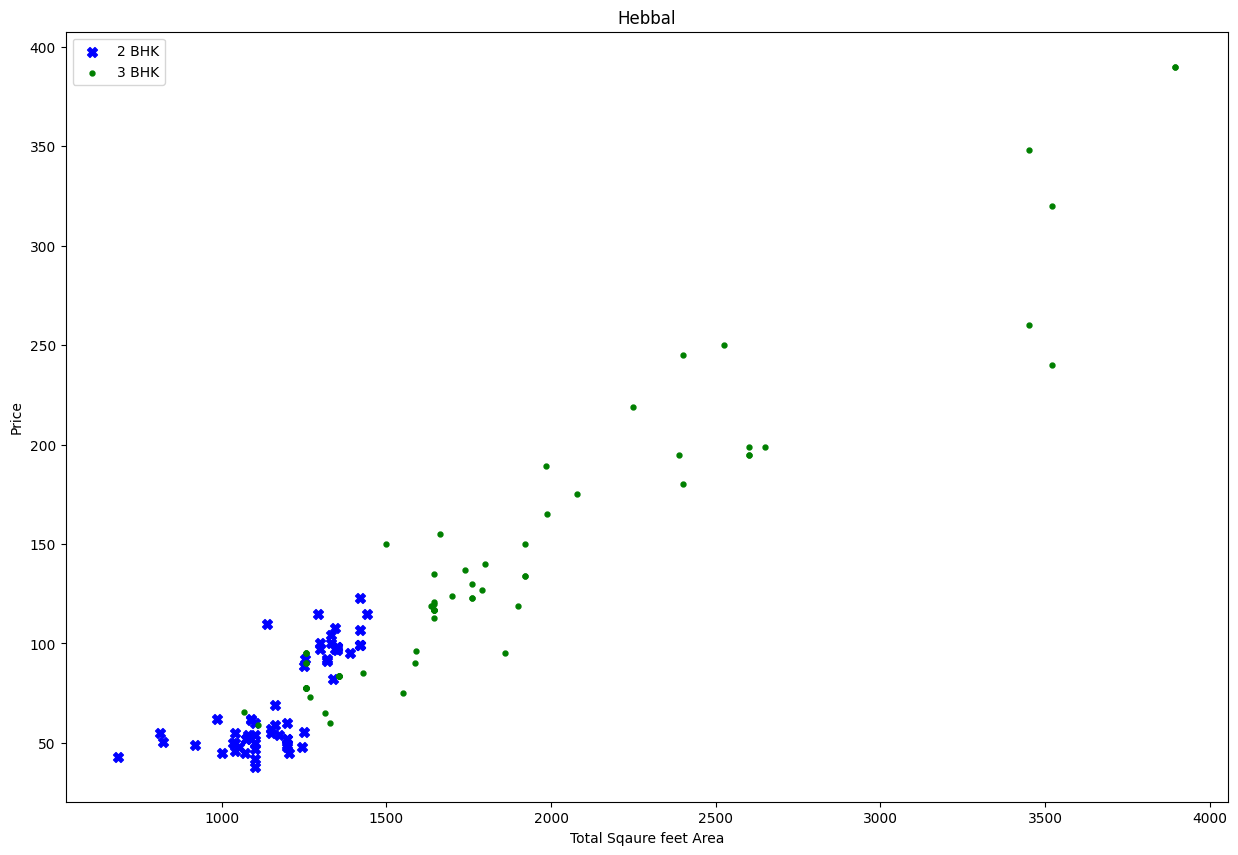

In [42]:
plot_chart(df8,"Hebbal")


In [43]:
df8[df8.bath>10]


,location,total_sqft,bath,price,bhk,price_per_sqft
3096,other,12000.0,12.0,525.0,10,4375.00
3609,other,10000.0,16.0,550.0,16,5500.00
7979,other,6000.0,12.0,150.0,11,2500.00
8636,Neeladri Nagar,4000.0,12.0,160.0,10,4000.00
9935,other,5425.0,13.0,275.0,13,5069.12


It is unusual to have 2 more bathrooms than number of bedrooms in a home



In [44]:
df8[df8.bath>df8.bhk+2]


,location,total_sqft,bath,price,bhk,price_per_sqft
2620,other,11338.0,9.0,1000.0,6,8819.90
7709,Chikkabanavar,2460.0,7.0,80.0,4,3252.03
11366,Nagasandra,7000.0,8.0,450.0,4,6428.57
12103,Thanisandra,1806.0,6.0,116.0,3,6423.03


Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [45]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(10897, 6)

In [46]:
df9.head(2)


,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.38


In [47]:
df10 = df9.drop(['price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3


#Using One Hot Encoding For Location


In [48]:
dummies = pd.get_dummies(df10.location)
dummies

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13314,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13315,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
13317,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13318,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#to avoid dummy variable trap you should use one less column


In [49]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Electronic City Phase II,1056.0,2.0,39.07,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Chikka Tirupathi,2600.0,5.0,120.00,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Uttarahalli,1440.0,2.0,62.00,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Lingadheeranahalli,1521.0,3.0,95.00,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Kothanur,1200.0,2.0,51.00,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


droping the location column

In [50]:
df12  = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1056.0,2.0,39.07,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2600.0,5.0,120.00,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False




> model preprocessing



In [51]:
X = df12.drop('price',axis= 'columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1056.0,2.0,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2600.0,5.0,4,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1440.0,2.0,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1521.0,3.0,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1200.0,2.0,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
Y = df12['price']
Y

0         39.07
1        120.00
2         62.00
3         95.00
4         51.00
          ...  
13314    112.00
13315    231.00
13317     60.00
13318    488.00
13319     17.00
Name: price, Length: 10897, dtype: float64



> splitting for train and test



In [53]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

#linear Regression

In [54]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8952507585434678

#Use K Fold cross validation to measure accuracy of our LinearRegression model

In [55]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, Y, cv=cv)

array([0.81579445, 0.87317157, 0.81538124, 0.78846656, 0.83966658])

#finding best model using grid searchCV

In [56]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['squared_error','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,Y)


,model,best_score,best_params
0,linear_regression,0.826496,{'positive': False}
1,lasso,0.795899,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.775071,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [57]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)

In [58]:
np.where(X.columns == 'Vishwapriya Layout')[0][0]

np.int64(235)

In [59]:
def predict_price(location,total_sqft,bath,bhk):
    loc_index = np.where(X.columns == location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = total_sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]
predict_price('1st Phase JP Nagar',1000,2,2)

/home/yuvraj/Desktop/CODE/real_estate_prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(90.64881391899893)

In [60]:
print(predict_price('1st Phase JP Nagar',1000,3,3))
print(predict_price('Indira Nagar',1000,2,2))
print(predict_price('Indira Nagar',1000,2,3))
print(predict_price('Indira Nagar',1010,3,3))
print(predict_price('Indira Nagar',3000,4,4))

88.22459054755561
93.12532458910107
88.2590826467655
91.4176127621443
231.5791867435208


/home/yuvraj/Desktop/CODE/real_estate_prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/yuvraj/Desktop/CODE/real_estate_prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/yuvraj/Desktop/CODE/real_estate_prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/yuvraj/Desktop/CODE/real_estate_prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/yuvraj/Desktop/CODE/real_estate_prediction/.venv/l

#model extaction

In [61]:
import pickle
with open('bengaluru_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

#column storage in json

In [62]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))